In [42]:
#!pip install numpy
#!pip install sklearn

In [43]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report , accuracy_score, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix

RANDOM_STATE = 1

In [44]:
from IPython.core.display import HTML
HTML("""
<style>
.consignes{
  font-weight: bold;
  color: #3256a8;
  background-color: #edebdf
}
</style>
""")



# TP2: Détection de menaces radar

<div class=consignes> Listez les noms des étudiants (2 au maximum) ayant participé à ce notebook dans la cellule suivante (prénom, nom, affectation).<br/>
Au moment du rendu, le notebook doit être nommé nom1_nom2_dlts_tp2.ipynb 

2 séances de TP sur ce sujet : le 15 octobre (1h30) et le 22 octobre (3h).<br> 
Deadline : 29 otobre 2025, 13h59, par mail à deepetsignal.mva@gmail.com <br> 

Pour installer les paquets nécessaires à la réalisation de ce TP vous pouvez utiliser dans le notebook 
    
```
!pip install \< nom_du_paquet \>
```
merci de regrouper toutes les installations dans la première cellule du notebook. 
Essayez de faire en sorte que votre notebook puisse se lire comme un compte rendu, évitez de laisser du code mort et prennez le temps de commenter vos observations et résultats.

    
## Mission


Vous commandez un avion de reconnaissance en mission top secrète. Malgré votre discretion et toutes les précautions prises vous dérangez et pouvez être sujet de menaces qu'il vous faut détecter pour garantir la sécurité de votre équipage et la succès de votre mission (comme elle est top secrète vous ne pouvez pas en savoir plus). 

A votre disposition un réseau d'antennes et un système d'analyse spectrale perfectionnés vous permettent d'extraire et de caractériser des signaux en provenance des radars à altitude 0 qui parsèment votre parcours. 

Un signal radar est composé d'impulsions. Le système d'analyse vous permettent de caractériser chaque impulsion reçue par un PDW (Pulse Description Word) qui contient: 

- la date de début de détection de l'impulsion (en ms)
- la largeur ou durée de l'impulsion (en ms)
- la puissance de l'impulsion (en dB / référence) 
- l'angle theta et l'angle phi décrivant la direction dans laquelle l'impulsion est détectée (en radians)
- la fréquence de l'impulsion (en Ghz)

Votre capteur n'est pas parfait et vous subissez notamment un phénomène de mitage: une certaine proportion des impulsions émises ne sont pas détectées. Cette proportion est d'autant plus grande que la puissance des impulsions est petite.  

Votre vaisseau navigue à 10 km d'altitude, avec une vitesse constante de 1000 km/h vers le nord. 

De précédentes missions ont permis de réaliser une base de données de signaux de 10 secondes. 
Chaque signal se présente sous la forme d'un fichier .npz qui contient l'ensemble des PDW reçus. 

Un signal est donc un fichier dont le nom est de la forme 'pdw_<numéro du signal>.npz'.

Cette base de données est annotée: le destin de chaque mission a permis de déclarer chaque signal comme une 'menace' ou une 'nonmenace'. 

Les signaux ont été divisés en deux ensembles indépendants: 
    
- train
- test 
 
Les annotations pour chaque ensemble sont disponibles dans le fichier labels_<train ou test>.json qui donne l'association nom de fichier -> menace ou nonmenace. 
    
    
Votre mission (si vous l'acceptez) est de choisir et d'entrainer un algorithme d'apprentissage machine à détecter les menaces sur l'ensemble 'train' et à évaluer ses performances sur l'ensemble 'test'. 

Fort de votre expérience passée, vous décidez de suivre la méthodologie suivante: 

- Visualisation et analyse des données pour trouver les paramètres les plus pertinents à utiliser 
- Sélection d'un algorithme naïf "baseline" de référence: vous définissez un premier algorithme simple et caractérisez ses performances qui serviront de point de comparaison pour qualifier l'apport d'algorithmes plus sophistiqués 
- Vous utilisez la bibliothèque sklearn et notamment ses implémentations d'algorithmes de classification binaire pour définir et entrainer sur l'ensemble 'train' un ou plusieurs algorithmes en capacité de prédire le label menance ou nonmenace de chaque signal (https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)
- Vous qualifiez les performances de vos algorithmes en termes d'accuracy (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score) ; vous calculez aussi les matrices de confusion (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)
    
Pour ce TP nous ne cherchons pas à mettre en place des algorithmes d'apprentissage profond. Ces méthodes pourront être investiguées dans un deuxième temps.
    
 Si les résultats vous semblent décevants, souvenez vous des conseils de votre prédecesseur et mentor G. Abitbol: "toujours donner un coup de pouce à un algo de machine learning  en lui présentant les bonnes données"

Vous pouvez ouvrir un fichier de la façon suivante:

</div>    

In [45]:
pdws = np.load('./radars/train/pdw-0.npz')
dates = pdws['date']
largeurs = pdws['largeur']
frequences=pdws['puissance']
puissances = pdws['puissance']
theta = pdws['theta']
phi = pdws['phi']


<div class=consignes> et les fichiers d'annotations:</div>

In [46]:
import json

with open('./radars/train_labels.json') as f: 
    dict_labels = json.load(f)

for i in range(10):
    print(f"Le signal pdw-{i}.npz est de type: {dict_labels[f'pdw-{i}']}")

Le signal pdw-0.npz est de type: nonmenace
Le signal pdw-1.npz est de type: nonmenace
Le signal pdw-2.npz est de type: menace
Le signal pdw-3.npz est de type: nonmenace
Le signal pdw-4.npz est de type: nonmenace
Le signal pdw-5.npz est de type: menace
Le signal pdw-6.npz est de type: menace
Le signal pdw-7.npz est de type: menace
Le signal pdw-8.npz est de type: menace
Le signal pdw-9.npz est de type: nonmenace


<div class=consignes> On compte sur vous, bonne chance ! </div>

## 1. Exploration visuelle des signaux radar

Pour mieux comprendre la nature des données, nous visualisons deux exemples typiques de signaux :

- un signal non-menace
- un signal menace

Chaque signal est représenté sous quatre vues complémentaires :  
1. Puissance en fonction du temps (colorée selon la fréquence)  
2. Puissance en fonction de la fréquence (colorée selon le temps)  
3. Distribution angulaire (`θ` vs `φ`, colorée selon la puissance)  
4. Distribution fréquentielle (histogramme des fréquences observées)

Ces graphiques permettent d’observer les caractéristiques physiques des émissions radar et de distinguer visuellement les comportements entre menaces et non-menaces


In [47]:
def plot_signal(path, label=None):
    data = np.load(path)
    dates = data['date']
    powers = data['puissance']
    widths = data['largeur']
    freqs = data['frequence']
    theta = data['theta']
    phi = data['phi']

    plt.figure(figsize=(16, 8))
    
    plt.subplot(2, 2, 1)
    plt.scatter(dates, powers, s=widths*10, alpha=0.6, c=freqs, cmap='viridis')
    plt.xlabel("Time (ms)")
    plt.ylabel("Power (dB)")
    plt.title(f"Power vs Time ({label})" if label else "Power vs Time")
    plt.colorbar(label="Frequency (GHz)")

    plt.subplot(2, 2, 2)
    plt.scatter(freqs, powers, s=widths*10, alpha=0.6, c=dates, cmap='plasma')
    plt.xlabel("Frequency (GHz)")
    plt.ylabel("Power (dB)")
    plt.title("Power vs Frequency")
    plt.colorbar(label="Time (ms)")

    plt.subplot(2, 2, 3)
    plt.scatter(theta, phi, c=powers, cmap='coolwarm', s=10)
    plt.xlabel("Theta (rad)")
    plt.ylabel("Phi (rad)")
    plt.title("Angular Distribution")
    plt.colorbar(label="Power (dB)")

    plt.subplot(2, 2, 4)
    plt.hist(freqs, bins=40, color='#00BFA6', edgecolor='white', alpha=0.9)
    plt.xlabel("Frequency (GHz)")
    plt.ylabel("Count")
    plt.title("Frequency Distribution")

    plt.tight_layout()
    plt.show()

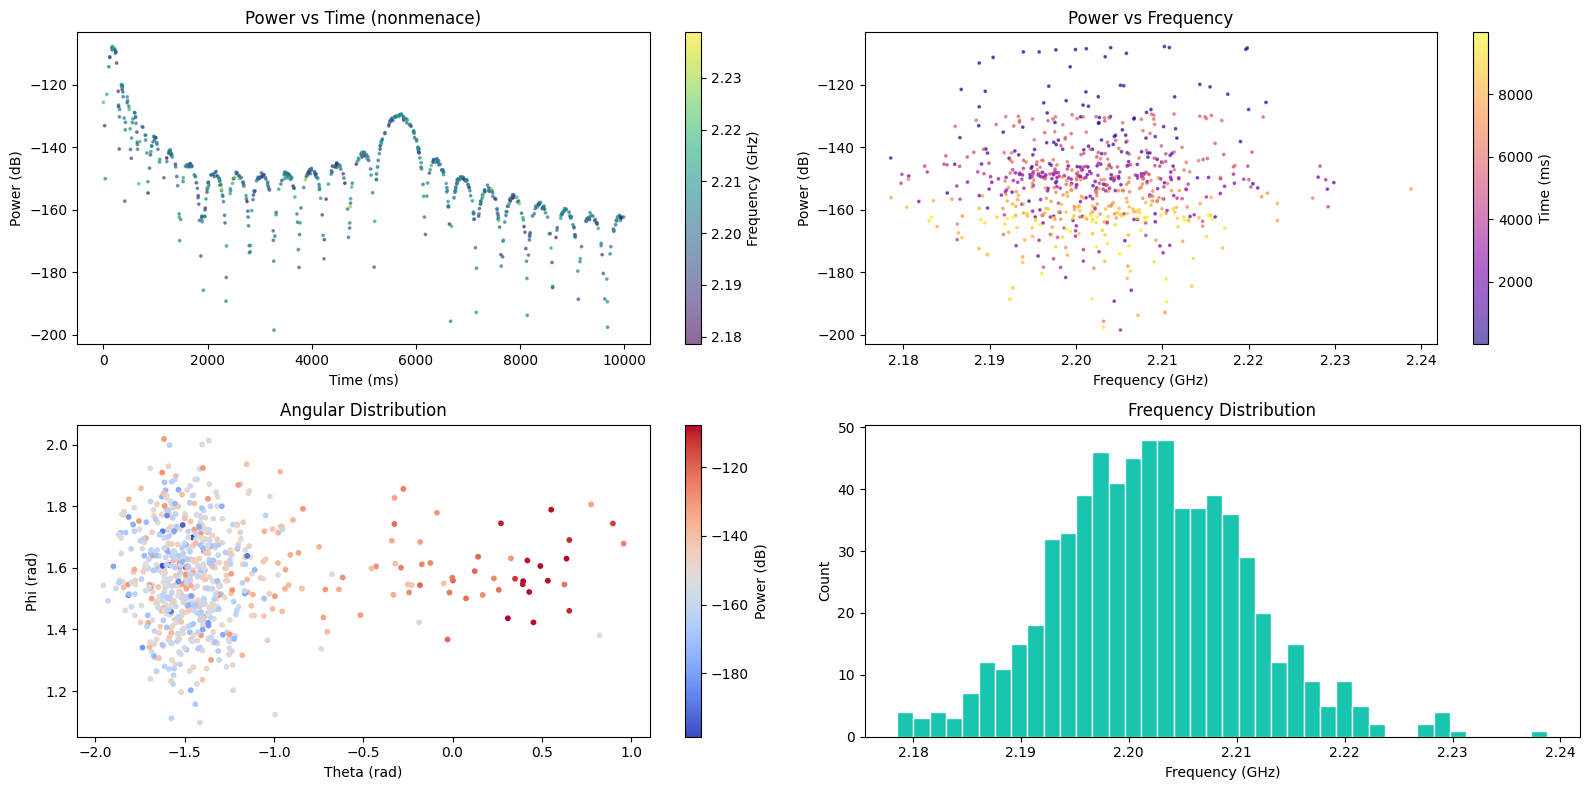

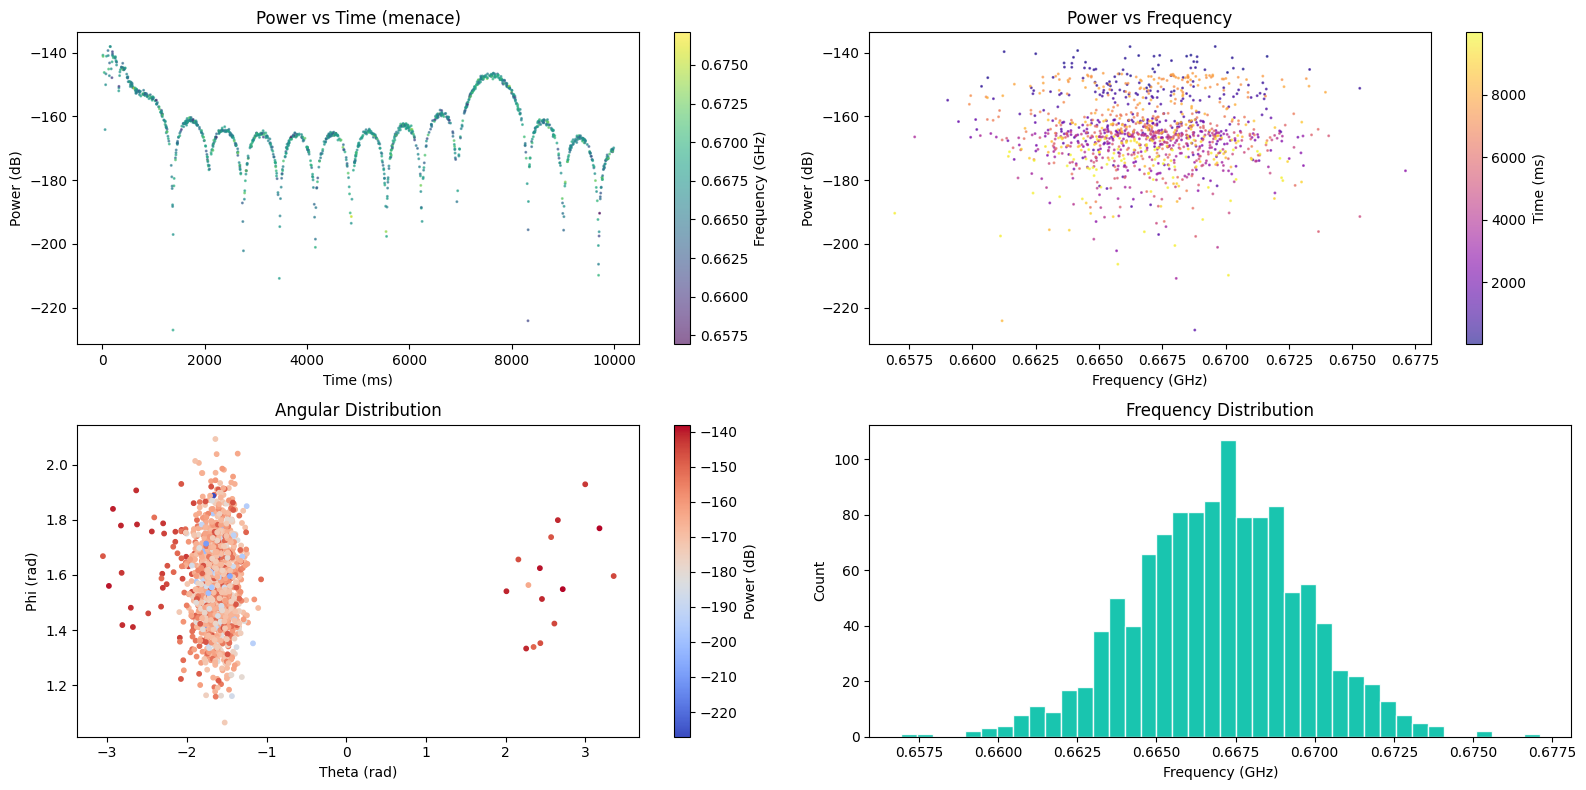

In [48]:
plot_signal("./radars/train/pdw-0.npz", label="nonmenace")
plot_signal("./radars/train/pdw-6.npz", label="menace")

### Observations

- Les signaux non-menaces (haut)  presentent une dispersion fréquentielle plus large, une puissance moyenne plus faible  et une  répartition angulaire plus diffuse .  
  - Cela traduit des impulsions plus  aleatoires typiques d’émissions environnementales ou non ciblées

- Les  signaux menaces  (bas) montrent une  frequence très stable  et une  puissance plus concentrée  autour  de valeurs élevées.  
  - Ces signatures sont caractéristiques d’un radar de poursuite ou de guidage, souvent dirigé vers la cible

Ces premières observations guident la construction des features dans la sute  du TP (variance frequentielle, puissance moyenne, stabilité angulaire, etc.)

## 2. Extraction des features

Chaque fichier `.npz` correspond à un signal radar de 10 secondes contenant plusieurs impulsions.  
Pour pouvoir entraîner un modèle de machine learning on transforme chaque signal en un  vecteur de caractéristiques numériques .

Les features calculées sont des statistiques simples sur les différentes variables :  
-  Puissance  : moyenne, ecart-type, maximum, pente dans le temps  
-  Fréquence : moyenne, ecart-type, pente dans le temps, plage de fréquences  
-  Largeur d’impulsion : moyenne, ecart-type  
-  Angles  : ecart-type de `theta` et `phi`, corrélation entre les deux  
-  Structure du signal  : nombre total d’impulsions et taux d’émission (`pulses/s`)

Les pentes (`p_slope_time`, `freq_slope_time`) sont calculées via une régression linéaire et indiquent si la puissance ou la fréquence évoluent dans le temps.

Enfin la fonction `load_dataset` parcourt tous les fichiers du dossier (train ou test) applique `extract_features` et construit un  DataFrame  où chaque ligne correspond à un signal


In [49]:
def slope(x, y):
    if len(x) < 2:
        return 0.0
    return float(LinearRegression().fit(x.reshape(-1, 1), y).coef_[0])

def extract_features(path):
    d = np.load(path)
    t, p, w, f, th, ph = d['date'], d['puissance'], d['largeur'], d['frequence'], d['theta'], d['phi']

    feats = {
        "mean_power": np.mean(p),
        "std_power": np.std(p),
        "max_power": np.max(p),
        "p_slope_time": slope(t, p),
        "mean_freq": np.mean(f),
        "std_freq": np.std(f),
        "freq_slope_time": slope(t, f),
        "freq_range": np.max(f) - np.min(f),
        "mean_width": np.mean(w),
        "std_width": np.std(w),
        "n_pulses": len(p),
        "theta_std": np.std(th),
        "phi_std": np.std(ph),
        "theta_phi_corr": float(np.nan_to_num(np.corrcoef(th, ph)[0, 1])),
        "pulse_rate": len(p) / (t.max() - t.min() + 1e-6),
    }
    return feats

def load_dataset(base_dir, label_file=None):
    rows = []

    labels = None
    if label_file is not None and os.path.exists(label_file):
        with open(label_file) as f:
            labels = json.load(f)

    for file in os.listdir(base_dir):
        if not file.endswith(".npz"):
            continue
        path = Path(base_dir) / file
        feats = extract_features(path)
        feats["file"] = file
        if labels:
            feats["label"] = 1 if labels[file.replace(".npz", "")] == "menace" else 0
        rows.append(feats)

    df = pd.DataFrame(rows)
    print(f"Loaded {len(df)} signals from {base_dir}")
    return df


In [50]:
df_train = load_dataset("./radars/train", "./radars/train_labels.json")
df_test = load_dataset("./radars/test", "./radars/test_labels.json")

Loaded 2000 signals from ./radars/train
Loaded 800 signals from ./radars/test


In [51]:
df_train.head()

,mean_power,std_power,max_power,p_slope_time,mean_freq,std_freq,freq_slope_time,freq_range,mean_width,std_width,n_pulses,theta_std,phi_std,theta_phi_corr,pulse_rate,file,label
0,-169.695605,10.626068,-144.164735,-0.000854,1.752959,0.007215,-1.939897e-07,0.041975,0.211989,0.000809,616,0.531704,0.157754,-0.066989,0.061898,pdw-833.npz,1
1,-172.846118,11.080258,-150.669584,-0.001547,0.977732,0.057532,-2.179155e-07,0.201978,0.183026,0.000817,1350,0.203140,0.156347,0.011650,0.135049,pdw-199.npz,1
2,-158.148846,9.452756,-134.844631,-0.001274,4.030166,0.016381,-6.228437e-08,0.116261,0.027005,0.000829,2836,0.162211,0.156944,0.000919,0.283630,pdw-1159.npz,0
3,-120.617201,7.463221,-96.882321,-0.002380,0.925681,0.054288,-3.624745e-08,0.187031,0.065007,0.000822,2222,0.265600,0.154187,-0.013357,0.222406,pdw-827.npz,1
4,-157.989704,12.958175,-106.022968,-0.001646,1.159271,0.068435,7.404476e-07,0.234756,0.328940,0.000802,679,0.366526,0.155255,0.010005,0.067965,pdw-1171.npz,1


In [52]:
df_train.describe()

,mean_power,std_power,max_power,p_slope_time,mean_freq,std_freq,freq_slope_time,freq_range,mean_width,std_width,n_pulses,theta_std,phi_std,theta_phi_corr,pulse_rate,label
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2.000000e+03,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,-155.158325,11.490236,-121.507942,-0.001735,1.928007,0.024230,2.919267e-09,0.104748,0.149072,0.000816,1698.798000,0.333210,0.157118,0.008310,0.170077,0.494500
std,15.226050,1.742810,17.706193,0.000932,0.878697,0.035083,4.554088e-07,0.114442,0.100390,0.000009,1842.561227,0.186721,0.003536,0.034644,0.184257,0.500095
min,-214.579241,6.311735,-181.557664,-0.004528,0.542676,0.002117,-3.176770e-06,0.013582,0.003997,0.000773,458.000000,0.145277,0.142163,-0.096141,0.046006,0.000000
25%,-163.064088,10.627863,-133.037281,-0.002422,1.240717,0.005783,-6.453952e-08,0.038441,0.069738,0.000811,692.750000,0.184999,0.155014,-0.013198,0.069448,0.000000
50%,-155.894977,11.805074,-124.852959,-0.001904,1.748150,0.008727,-2.648039e-09,0.057984,0.130064,0.000816,1013.500000,0.246144,0.157072,0.007545,0.101492,0.000000
75%,-149.933744,12.593724,-107.479034,-0.001210,2.437274,0.015065,6.045592e-08,0.102602,0.210985,0.000822,1855.250000,0.440188,0.159361,0.028884,0.185683,1.000000
max,-118.893784,17.886904,-69.610802,0.001454,4.981212,0.173049,4.053944e-06,0.604684,0.486997,0.000854,20014.000000,0.925111,0.169202,0.172607,2.001498,1.000000


In [53]:
df_test.head()

,mean_power,std_power,max_power,p_slope_time,mean_freq,std_freq,freq_slope_time,freq_range,mean_width,std_width,n_pulses,theta_std,phi_std,theta_phi_corr,pulse_rate,file,label
0,-121.255259,6.684050,-100.274581,-0.002181,1.863927,0.007718,-7.198242e-08,0.040979,0.172957,0.000822,627,0.185057,0.162248,0.044420,0.062836,pdw-199.npz,1
1,-145.063136,11.044959,-121.342223,-0.001757,3.185156,0.012916,4.890891e-08,0.089129,0.014994,0.000818,5499,0.161017,0.156152,0.002023,0.550286,pdw-628.npz,0
2,-192.396178,10.198630,-175.198003,0.000652,3.190951,0.012797,9.417791e-09,0.089175,0.031009,0.000816,4040,0.206236,0.156969,0.031677,0.404368,pdw-614.npz,0
3,-154.679632,11.276606,-114.902775,-0.001942,0.925552,0.003620,3.857003e-08,0.022927,0.146032,0.000803,1037,0.642088,0.154404,0.001563,0.103772,pdw-172.npz,1
4,-156.012349,9.153624,-122.366890,-0.001545,1.794339,0.007113,1.794986e-08,0.052327,0.218992,0.000817,1057,0.317396,0.157054,0.015362,0.105891,pdw-166.npz,1


In [54]:
df_test.describe()

,mean_power,std_power,max_power,p_slope_time,mean_freq,std_freq,freq_slope_time,freq_range,mean_width,std_width,n_pulses,theta_std,phi_std,theta_phi_corr,pulse_rate,label
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,8.000000e+02,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,-155.231105,11.448301,-121.915855,-0.001697,1.973420,0.023323,2.690257e-08,0.102559,0.143379,0.000816,1839.030000,0.326323,0.157020,0.006495,0.184093,0.481250
std,15.193046,1.757070,17.391793,0.000907,0.904777,0.034179,4.114504e-07,0.111119,0.098820,0.000009,2032.140368,0.183869,0.003637,0.034313,0.203214,0.499961
min,-215.209435,6.225871,-175.620142,-0.003848,0.541403,0.002161,-3.398466e-06,0.014933,0.003007,0.000775,470.000000,0.148277,0.144363,-0.149511,0.047216,0.000000
25%,-162.500214,10.583694,-132.689173,-0.002340,1.281459,0.005848,-6.510636e-08,0.038843,0.065006,0.000811,716.250000,0.187689,0.154940,-0.013748,0.071832,0.000000
50%,-155.835456,11.748215,-124.477624,-0.001910,1.767351,0.008749,5.710586e-11,0.058754,0.120496,0.000816,1047.500000,0.238425,0.157119,0.006807,0.104868,0.000000
75%,-150.153568,12.570964,-110.256228,-0.001151,2.497001,0.014958,6.057683e-08,0.100091,0.210980,0.000821,2010.250000,0.432419,0.159016,0.026304,0.201170,1.000000
max,-118.899679,19.719496,-68.422730,0.000863,4.993488,0.165035,3.276772e-06,0.585088,0.460980,0.000849,19065.000000,0.885958,0.169626,0.188640,1.906623,1.000000


## 3. Corrélation entre les features

Avant de passer à l’entrainement on  regarde comment les différentes features sont reliées entre elles et avec le label (menace ou non)

La matrice de correlation ci-dessous montre la force du lien entre chaque variable
Les valeurs proches de 1 indiquent une forte corrélation positive celles proches de -1 une  corrélation négative


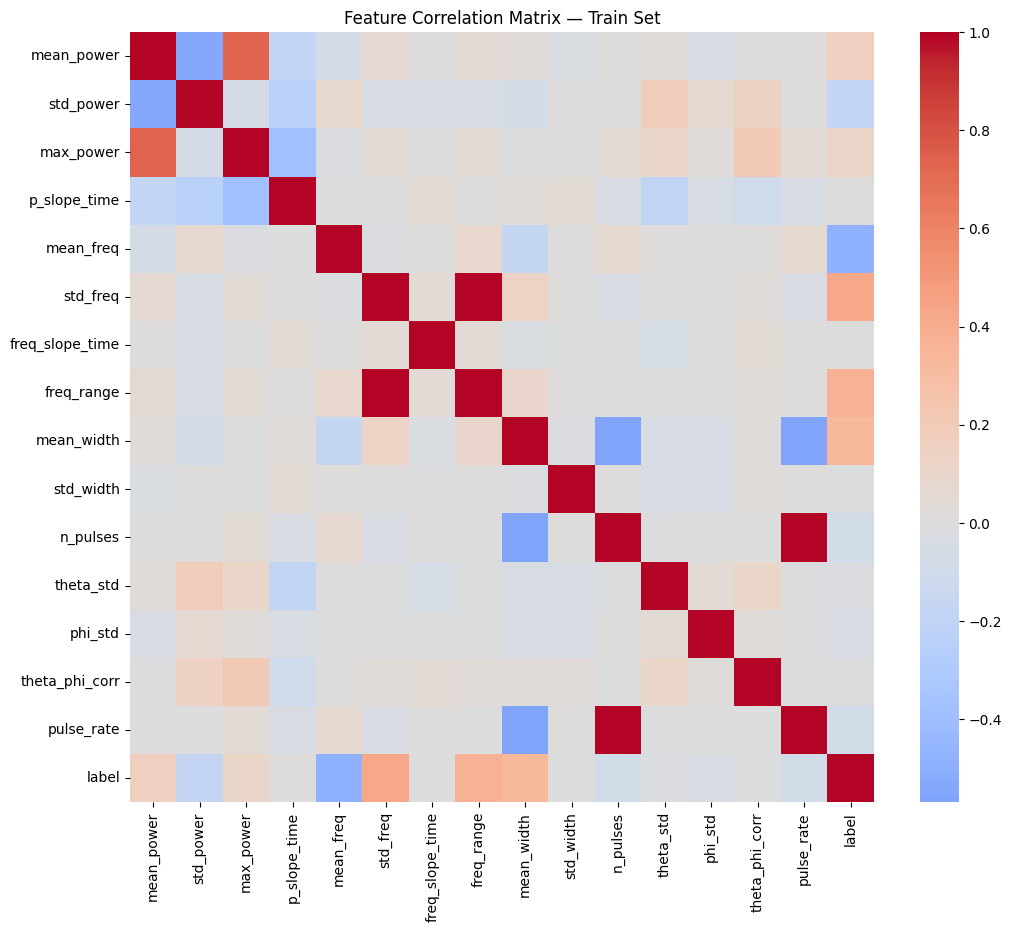

Correlation with label:
 label              1.000000
std_freq           0.428256
freq_range         0.374187
mean_width         0.337268
mean_power         0.154968
max_power          0.099621
p_slope_time       0.010695
freq_slope_time    0.001362
std_width         -0.011613
theta_phi_corr    -0.012228
theta_std         -0.017675
phi_std           -0.037380
pulse_rate        -0.081354
n_pulses          -0.081397
std_power         -0.175144
mean_freq         -0.482292
Name: label, dtype: float64


In [55]:
corr = df_train.drop(columns=["file"]).corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
plt.title("Feature Correlation Matrix — Train Set")
plt.show()
corr_label = corr["label"].sort_values(ascending=False)

print("Correlation with label:\n", corr_label)


### Observations

Les features liées à la fréquence (comme std_freq ou mean_freq) semblent les plus utiles : les signaux de menace ont souvent une fréquence plus stable.  
Les features de puissance (mean_power, std_power, max_power) sont aussi assez corrélées, ce qui montre que les menaces ont souvent des impulsions plus fortes et régulières.  
Les autres variables (theta_std, phi_std, pulse_rate) sont moins informatives seules, mais peuvent aider en combinaison avec d’autres.  

En résumé, la fréquence et la puissance sont les deux paramètres principaux pour différencier les menaces des non-menaces.


## 1. Préparer les données
On divise le jeu d’entraînement en deux parties :
- 80 % pour entraîner les modèles
- 20 % pour valider les performances

Le but est de tester plusieurs modèles sans toucher au jeu de test final.

In [56]:
feature_cols = [c for c in df_train.columns if c not in ("label","file")]
X = df_train[feature_cols].values
y = df_train["label"].values

X_tr, X_va, y_tr, y_va = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)


## 2. Essayer plusieurs modèles
On entraîne plusieurs modèles de classification :
- Régression logistique
- SVM à noyau RBF
- K-Nearest Neighbors
- Random Forest
- Gradient Boosting

Chaque modèle est entraîné sur la partie "train" puis évalué sur la "validation".  
Pour chaque modèle, on calcule :
- l’accuracy (taux de bonne prédiction)
- l’AUC (capacité à séparer les deux classes)

Le modèle avec la meilleure AUC est choisi pour la suite.

In [57]:

models = {
    "LogReg": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=500, class_weight="balanced", random_state=RANDOM_STATE))
    ]),
    "SVM-RBF": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=RANDOM_STATE))
    ]),
    "KNN": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", KNeighborsClassifier(n_neighbors=7))
    ]),
    "RandomForest": RandomForestClassifier(
        n_estimators=400, max_depth=None, min_samples_leaf=2, random_state=RANDOM_STATE, n_jobs=-1
    ),
    "GradBoost": GradientBoostingClassifier(random_state=RANDOM_STATE)
}

In [58]:
results = []
fitted = {}

for name, model in models.items():
    model.fit(X_tr, y_tr)
    fitted[name] = model
    va_proba = model.predict_proba(X_va)[:,1]
    va_pred  = (va_proba >= 0.5).astype(int)
    acc = accuracy_score(y_va, va_pred)
    auc = roc_auc_score(y_va, va_proba)
    results.append((name, acc, auc))

res_df = pd.DataFrame(results, columns=["model","val_accuracy","val_auc"]).sort_values("val_auc", ascending=False)
print(res_df)

          model  val_accuracy   val_auc
4     GradBoost        0.8925  0.962846
3  RandomForest        0.8775  0.961671
1       SVM-RBF        0.8825  0.954620
2           KNN        0.8450  0.924755
0        LogReg        0.8350  0.913916


Best model: GradBoost
              precision    recall  f1-score   support

  Non-menace       0.92      0.97      0.94       202
      Menace       0.97      0.91      0.94       198

    accuracy                           0.94       400
   macro avg       0.94      0.94      0.94       400
weighted avg       0.94      0.94      0.94       400



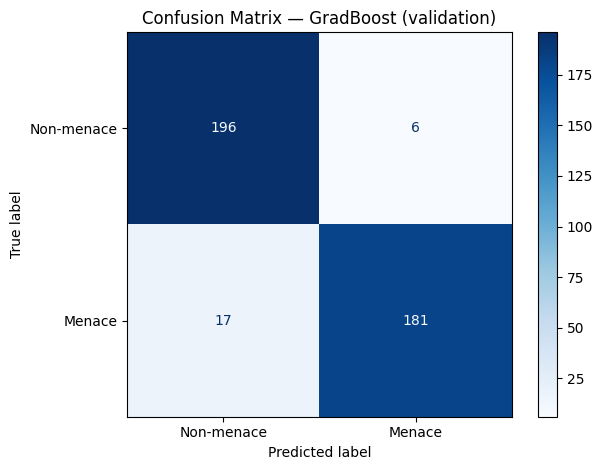

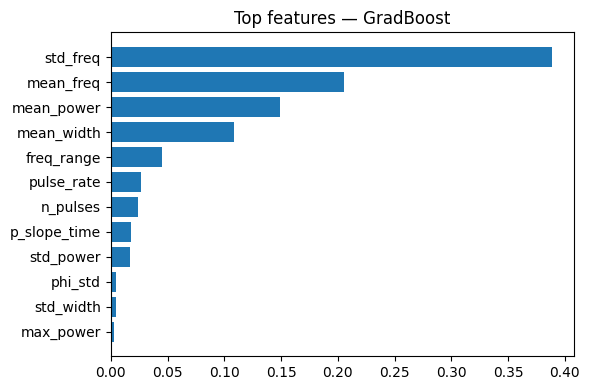

In [61]:

best_name = res_df.iloc[0]["model"]
best_model = fitted[best_name]
print("Best model:", best_name)

y_va_pred = best_model.predict(X_va)
print(classification_report(y_va, y_va_pred, target_names=["Non-menace", "Menace"]))


# Confusion matrix sur la validation
ConfusionMatrixDisplay.from_estimator(best_model, X_va, y_va, display_labels=["Non-menace", "Menace"], cmap="Blues")
plt.title(f"Confusion Matrix — {best_name} (validation)")
plt.tight_layout()
plt.show()

# Importances des variables
importances = best_model.feature_importances_
idx = np.argsort(importances)[::-1][:12]

plt.figure(figsize=(6,4))
plt.barh(np.array(feature_cols)[idx][::-1], importances[idx][::-1])
plt.title(f"Top features — {best_name}")
plt.tight_layout()
plt.show()



Le modèle fait peu de fausses alertes et détecte correctement la majorité des menaces.  
Quelques menaces sont encore manquées, mais le compromis entre précision et rappel reste équilibré.

### Importance des variables
Les variables les plus utiles pour la décision sont :
- **std_freq** : variation de fréquence, très discriminante.  
- **mean_freq** : fréquence moyenne du signal.  
- **mean_power** et **mean_width** : puissance et largeur moyenne des impulsions.  

Les autres variables ont un impact plus faible ou sont redondantes.  
On en conclut que la fréquence et la puissance sont les indicateurs principaux pour identifier une menace radar.


## Réentraînement complet

On réentraîne le meilleur modèle (ici le Gradient Boosting) sur  tout le jeu d’entraînement complet   
pour qu’il dispose de plus de données avant l’évaluation finale.


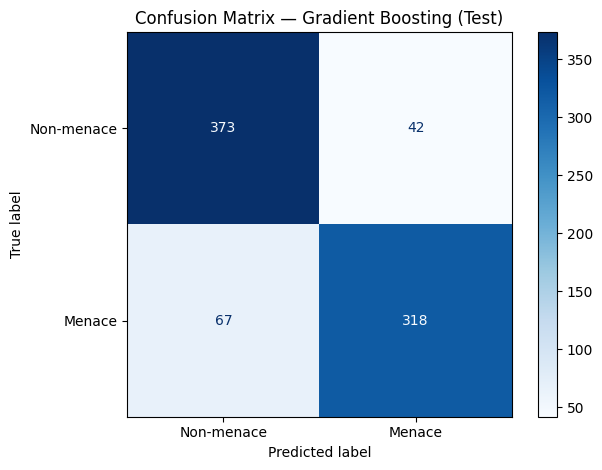

              precision    recall  f1-score   support

  Non-menace       0.85      0.90      0.87       415
      Menace       0.88      0.83      0.85       385

    accuracy                           0.86       800
   macro avg       0.87      0.86      0.86       800
weighted avg       0.86      0.86      0.86       800



In [60]:
# train on full train and predict testt
X_full = df_train[feature_cols].values
y_full = df_train["label"].values
best_model.fit(X_full, y_full)

X_test = df_test[feature_cols].values
test_proba = best_model.predict_proba(X_test)[:,1]
test_pred  = (test_proba >= 0.5).astype(int)

with open("./radars/test_labels.json") as f:
    true_labels_dict = json.load(f)

y_test_true = df_test["file"].map(
    lambda f: 1 if true_labels_dict[f.replace(".npz", "")] == "menace" else 0
)

cm = confusion_matrix(y_test_true, test_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Non-menace", "Menace"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix — Gradient Boosting (Test)")
plt.tight_layout()
plt.show()
print(classification_report(y_test_true, test_pred, target_names=["Non-menace", "Menace"]))

## Étape 6 — Interprétation finale

Le modèle atteint  86 % de précision globale sur le jeu de test,  
avec un bon équilibre entre les deux classes :

| Classe | Précision | Rappel | F1-score |
|:-------|:----------|:--------|:----------|
| Non-menace | 0.85 | 0.90 | 0.87 |
| Menace | 0.88 | 0.83 | 0.85 |

Ces résultats montrent que :
- Le modèle identifie correctement la majorité des menaces (rappel de 0.83).
- Il limite bien les fausses alertes sur les signaux non dangereux (précision de 0.85).
- Le compromis entre précision et rappel est solide (F1 ≈ 0.86).

En termes d’interprétation physique :
- Les  signaux de menace  ont une fréquence plus stable et une puissance plus élevée.
- Le  Gradient Boosting s’appuie principalement sur la structure fréquentielle (moyenne et écart-type) pour distinguer les deux classes.
- Quelques confusions persistent, mais la séparation globale reste nette.

En conclusion, le modèle offre un bon équilibre entre  performance  et  interprétabilité ,  
ce qui en fait une solution efficace pour la détection automatique de menaces radar.
